# Plotting Important Data: Visualizing the CMA Strategy
https://deap.readthedocs.io/en/master/examples/cmaes_plotting.html
https://github.com/DEAP/deap/blob/f141d3fe690e85a2748dae5b73f14ad5e9f784ad/examples/es/cma_plotting.py


In [2]:
%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Program Files\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


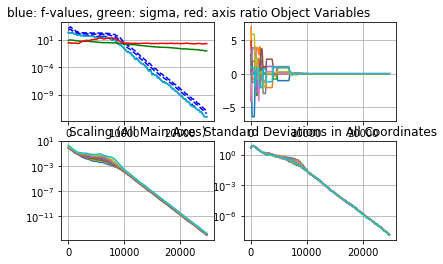

In [3]:
import numpy

from deap import algorithms
from deap import base
from deap import benchmarks
from deap import cma
from deap import creator
from deap import tools

import matplotlib.pyplot as plt

# Problem size
N = 10
NGEN = 125

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", benchmarks.rastrigin)

def main(verbose=True):
    # The cma module uses the numpy random number generator
    numpy.random.seed(64)

    # The CMA-ES algorithm takes a population of one individual as argument
    # The centroid is set to a vector of 5.0 see http://www.lri.fr/~hansen/cmaes_inmatlab.html
    # for more details about the rastrigin and other tests for CMA-ES    
    strategy = cma.Strategy(centroid=[5.0]*N, sigma=5.0, lambda_=20*N)
    toolbox.register("generate", strategy.generate, creator.Individual)
    toolbox.register("update", strategy.update)

    halloffame = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
    
    # Objects that will compile the data
    sigma = numpy.ndarray((NGEN,1))
    axis_ratio = numpy.ndarray((NGEN,1))
    diagD = numpy.ndarray((NGEN,N))
    fbest = numpy.ndarray((NGEN,1))
    best = numpy.ndarray((NGEN,N))
    std = numpy.ndarray((NGEN,N))

    for gen in range(NGEN):
        # Generate a new population
        population = toolbox.generate()
        # Evaluate the individuals
        fitnesses = toolbox.map(toolbox.evaluate, population)
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit
        
        # Update the strategy with the evaluated individuals
        toolbox.update(population)
        
        # Update the hall of fame and the statistics with the
        # currently evaluated population
        halloffame.update(population)
        record = stats.compile(population)
        logbook.record(evals=len(population), gen=gen, **record)
        
        if verbose:
            print(logbook.stream)
        
        # Save more data along the evolution for latter plotting
        # diagD is sorted and sqrooted in the update method
        sigma[gen] = strategy.sigma
        axis_ratio[gen] = max(strategy.diagD)**2/min(strategy.diagD)**2
        diagD[gen, :N] = strategy.diagD**2
        fbest[gen] = halloffame[0].fitness.values
        best[gen, :N] = halloffame[0]
        std[gen, :N] = numpy.std(population, axis=0)

    # The x-axis will be the number of evaluations
    x = list(range(0, strategy.lambda_ * NGEN, strategy.lambda_))
    avg, max_, min_ = logbook.select("avg", "max", "min")
    plt.figure()
    plt.subplot(2, 2, 1)
    plt.semilogy(x, avg, "--b")
    plt.semilogy(x, max_, "--b")
    plt.semilogy(x, min_, "-b")
    plt.semilogy(x, fbest, "-c")
    plt.semilogy(x, sigma, "-g")
    plt.semilogy(x, axis_ratio, "-r")
    plt.grid(True)
    plt.title("blue: f-values, green: sigma, red: axis ratio")

    plt.subplot(2, 2, 2)
    plt.plot(x, best)
    plt.grid(True)
    plt.title("Object Variables")

    plt.subplot(2, 2, 3)
    plt.semilogy(x, diagD)
    plt.grid(True)
    plt.title("Scaling (All Main Axes)")

    plt.subplot(2, 2, 4)
    plt.semilogy(x, std)
    plt.grid(True)
    plt.title("Standard Deviations in All Coordinates")
    
    plt.show()

if __name__ == "__main__":
    main(False)